In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tikzplotlib

In [2]:
x = np.exp(np.linspace(np.log10(0.001), np.log10(1), 5)) #([0.9, 0.5, 0.2, 0.1])[::-1]
y = x[::-1]

cs = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']

paretocolor = cs[0]
trncolor = cs[1]
tstcolor = cs[0]
optcolor = tstcolor
pescolor = cs[3] 
shiftcolor = cs[2]

In [3]:
def plot_pareto(fig, x, y, **kwargs):
    sort_idx = np.argsort(x)[::-1]
    new_x = [1] + list(x[sort_idx]) + [x[sort_idx[-1]]]
    new_y = [y[sort_idx[0]]] + list(y[sort_idx]) + [1]
    fig.step(new_x, new_y, where="pre", **kwargs)
    
def plot_points(fig, x, y, **kwargs):
    fig.scatter(x, y, **kwargs)

def plot_shift(fig, origx, origy, newx, newy, **kwargs):
    for orx, ory, nex, ney in zip(origx, origy, newx, newy):
        fig.quiver(orx, ory, nex-orx, ney-ory, angles="xy", scale_units="xy", scale=1, alpha=0.25, **kwargs)
        #fig.arrow(x=orx, y=ory, dx=nex-orx, dy=ney-ory, zorder=0,
        #          width=0.001, length_includes_head=True, **kwargs)

def setup_figure(ox, oy, nx, ny):
    ffig = plt.figure(figsize=[4,4], dpi=300)
    fig = ffig.add_subplot()
    plot_pareto(fig, ox, oy, color=trncolor, label="val pareto set", linestyle=":", marker="o")
    plot_shift(fig, ox, oy, nx, ny, color=shiftcolor)
    return fig, ffig

def unify_figure(fig, ffig):
    #fig.legend()
    fig.set_ylim([0, 1])
    fig.set_xlim([0, 1])
    fig.set_xlabel("Objective 1", fontsize=14)
    fig.set_ylabel("Objective 2", fontsize=14)
    ax = fig.axes
    ax.tick_params(axis="both", which="major", labelsize=12)
    ffig.tight_layout(pad=0)

def limx(x, l, u):
    x[x > u] = u
    x[x < l] = l
    return x

def get_pareto(x, y, opt=True):
    new_x, new_y = [], []
    for a, b in zip(x, y):
        is_p = True
        for i, j in zip(x, y):
            if opt and a > i and b > j:
                is_p = False
                break
            if not opt and a < i and b < j:
                is_p = False
                break
        if is_p:
            new_x.append(a)
            new_y.append(b)
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    return new_x, new_y

def merge_data(ox, oy, px, py):
    po = pd.DataFrame(index=ox, data={"o": oy})
    pp = pd.DataFrame(index=px, data={"p": py})
    newp = pd.concat([po, pp]).sort_index().ffill().bfill()
    newp = newp[~newp.index.duplicated(keep='first')]
    merged_x, merged_oy, merged_py = newp.index.to_numpy(), newp["o"].to_numpy(), newp["p"].to_numpy()
    merged_x = [merged_x[-1]] + list(merged_x) + [1]
    merged_oy = [1] + list(merged_oy) + [merged_oy[0]]
    merged_py = [1] + list(merged_py) + [merged_py[0]]
    print(merged_x)
    return merged_x, merged_oy, merged_py

[0.8269184741350643, 0.05, 0.18, 0.2277505072918794, 0.328764510601121, 0.6869602771722488, 0.8269184741350643, 1]


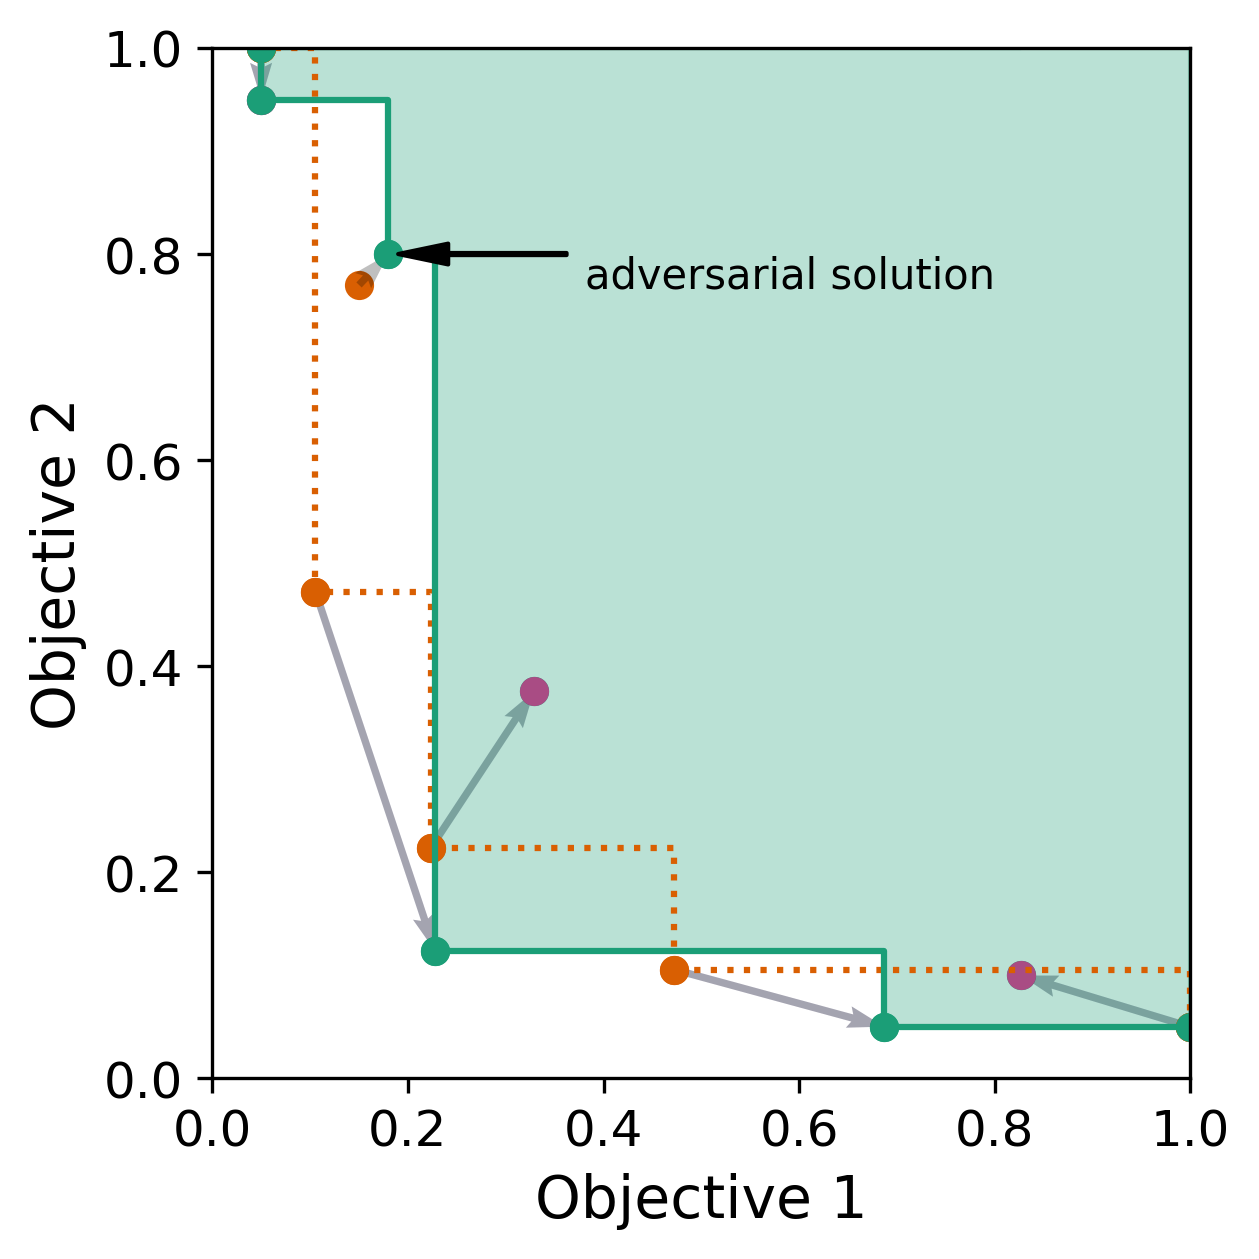

In [4]:
rng = np.random.RandomState(1)
test_x = x - rng.randn(x.shape[0])*0.2
test_y = y - rng.randn(x.shape[0])*0.2
test_x = limx(test_x, 0.05, 0.95)
test_y = limx(test_y, 0.05, 0.95)

x_with_adversarial = np.concatenate((x, [0.15]))
y_with_adversarial = np.concatenate((y, [0.77]))
x_test_with_adversarial = np.concatenate((test_x, [0.18]))
y_test_with_adversarial = np.concatenate((test_y, [0.8]))

fig, ffig = setup_figure(ox=x, oy=y, nx=test_x, ny=test_y)
plot_points(fig, x_with_adversarial, y_with_adversarial, color=trncolor, marker="o")
plot_points(fig, x_test_with_adversarial, y_test_with_adversarial, color=optcolor, marker="o")
plot_shift(fig, x_with_adversarial, y_with_adversarial, x_test_with_adversarial, y_test_with_adversarial)

ox, oy = get_pareto(x_test_with_adversarial, y_test_with_adversarial, opt=True)
plot_pareto(fig, ox, oy, label="optimistic set", color=optcolor, marker="o")

px, py = get_pareto(test_x, test_y, opt=False)
plot_points(fig, px, py, color=pescolor, marker="o")

merged_x, merged_oy, merged_py = merge_data(ox, oy, x_test_with_adversarial, y_test_with_adversarial)
fig.fill_between(merged_x, merged_oy, np.ones_like(merged_x), step="post", alpha=0.3, 
                 facecolor=optcolor, edgecolor=optcolor, label="difference")

fig.annotate('adversarial solution', xy=(x_test_with_adversarial[-1], y_test_with_adversarial[-1]),  xycoords='data',
            xytext=(0.8, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )


#fig.step(test_x, test_y, where="post", label="test pareto front", color=paretocolor)
unify_figure(fig, ffig)
#tikzplotlib.save("paretodiff.tex")
ffig.savefig("figures/adversarial.pdf")

[0.8269184741350643, 0.05, 0.2277505072918794, 0.328764510601121, 0.6869602771722488, 0.8269184741350643, 1]


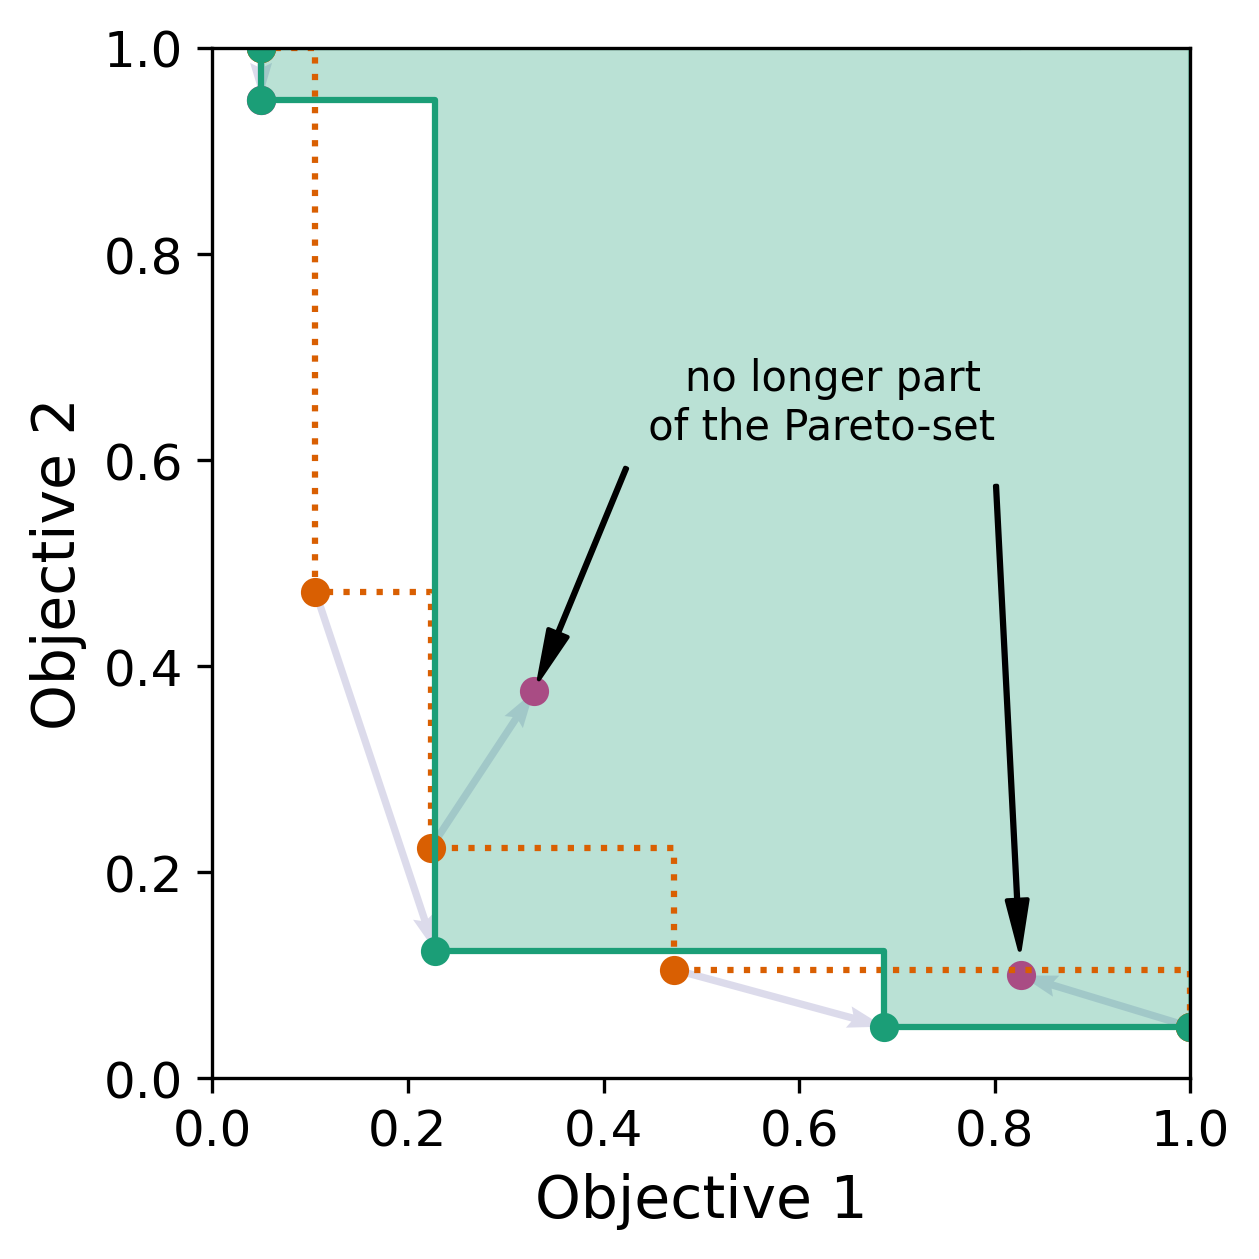

In [5]:
rng = np.random.RandomState(1)
test_x = x - rng.randn(x.shape[0])*0.2
test_y = y - rng.randn(x.shape[0])*0.2
test_x = limx(test_x, 0.05, 0.95)
test_y = limx(test_y, 0.05, 0.95)

fig, ffig = setup_figure(ox=x, oy=y, nx=test_x, ny=test_y)

ox, oy = get_pareto(test_x, test_y, opt=True)
plot_pareto(fig, ox, oy, label="optimistic set", color=optcolor, marker="o")

px, py = get_pareto(test_x, test_y, opt=False)
plot_points(fig, px, py, color=pescolor, marker="o")

merged_x, merged_oy, merged_py = merge_data(ox, oy, px, py)
fig.fill_between(merged_x, merged_oy, np.ones_like(merged_x), step="post", alpha=0.3, 
                 facecolor=optcolor, edgecolor=optcolor, label="difference")

fig.annotate('no longer part \n of the Pareto-set', xy=(px[1], py[1]),  xycoords='data',
            xytext=(0.8, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
fig.annotate('', xy=(px[2], py[2]),  xycoords='data',
            xytext=(0.8, 0.6), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )

#fig.step(test_x, test_y, where="post", label="test pareto front", color=paretocolor)
unify_figure(fig, ffig)
#tikzplotlib.save("paretodiff.tex")
ffig.savefig("figures/only_optimistic.pdf")

[0.8269184741350643, 0.05, 0.2277505072918794, 0.328764510601121, 0.6869602771722488, 0.8269184741350643, 1]


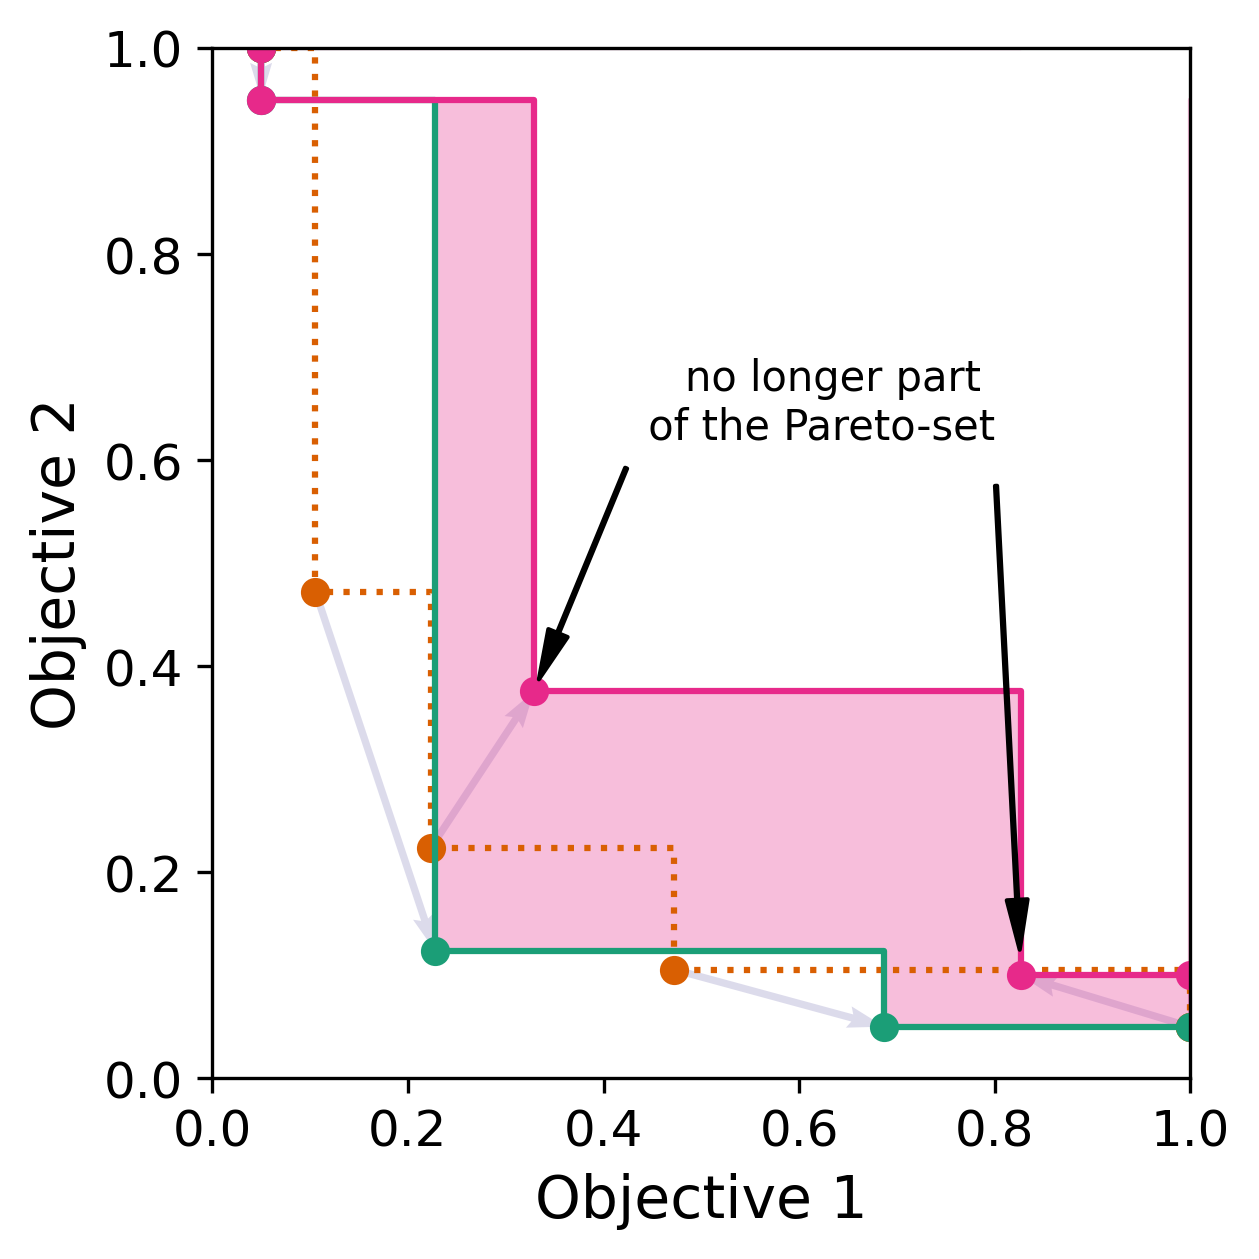

In [6]:
rng = np.random.RandomState(1)
test_x = x - rng.randn(x.shape[0])*0.2
test_y = y - rng.randn(x.shape[0])*0.2
test_x = limx(test_x, 0.05, 0.95)
test_y = limx(test_y, 0.05, 0.95)

fig, ffig = setup_figure(ox=x, oy=y, nx=test_x, ny=test_y)

ox, oy = get_pareto(test_x, test_y, opt=True)
plot_pareto(fig, ox, oy, label="optimistic set", color=optcolor, marker="o")

px, py = get_pareto(test_x, test_y, opt=False)
plot_pareto(fig, px, py, label="pessimistic set", color=pescolor, marker="o")

merged_x, merged_oy, merged_py = merge_data(ox, oy, px, py)
fig.fill_between(merged_x, merged_oy, merged_py, step="post", alpha=0.3, #hatch='\\', 
                 facecolor=pescolor, edgecolor=pescolor, label="difference")

fig.annotate('no longer part \n of the Pareto-set', xy=(px[1], py[1]),  xycoords='data',
            xytext=(0.8, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
fig.annotate('', xy=(px[2], py[2]),  xycoords='data',
            xytext=(0.8, 0.6), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )

#fig.step(test_x, test_y, where="post", label="test pareto front", color=paretocolor)
unify_figure(fig, ffig)
#tikzplotlib.save("paretodiff.tex")
ffig.savefig("figures/paretodiff.pdf")

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
f

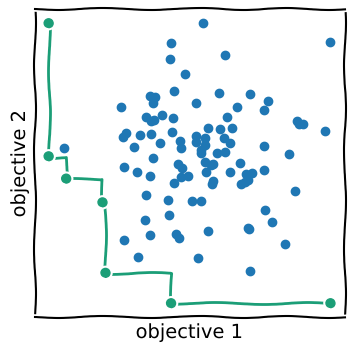

In [7]:
rng = np.random.RandomState(1)
test_x = rng.randn(100)
test_y = rng.randn(100)
test_x -= test_x.min()
test_x /= test_x.max()
test_y -= test_y.min()
test_y /= test_y.max()

with plt.xkcd():
    ffig = plt.figure(figsize=[4,4])
    fig = ffig.add_subplot()

    plt.scatter(test_x, test_y)

    xp, yp = get_pareto(test_x, test_y)
    plot_pareto(fig, xp, yp, label="optimistic set", color=optcolor, marker="o")

    plt.xlabel("objective 1")
    plt.ylabel("objective 2")


    plt.tick_params(axis='both', 
                    which='both', 
                    bottom=False, 
                    top=False,
                    labelbottom=False,
                    right=False,
                    left=False,
                    labelleft=False
                   )